# HEP Jet assignment project - Data analysis and particle finding script

## Import essential packages.
---
* We will use [uproot](https://github.com/scikit-hep/uproot) packages to parse our .root file.
* The content of function `particle properties` and `jet properties` is defined in `particle_properties.py` and `jet_properties.py`.

In [1]:
import uproot
import pandas as pd 
import numpy as np 
from particle_properties_uproot import particle_properties  #import particle properties helper function from particle_properties.py
from jet_properties_uproot import jet_properties  #import jet properties helper function from jet_properties.py
import h5py

## Loading data, determine parameters, and assign variable
---

In [2]:
data  = uproot.open('./data/10K_event/tag_1_delphes_events.root')['Delphes']
#data.show()

particle = particle_properties(data)
jet = jet_properties(data)

Length = len(particle.event)
test_length = 10

PID_W_plus = 24 
PID_W_minus = -24
PID_DOWN = 1
PID_DOWN_VAR = -1
PID_UP = 2
PID_UP_BAR = -2
PID_STRANGE = 3
PID_STRANGE_BAR = -3
PID_CHARM = 4
PID_CHARM_BAR = -4
PID_BOTTOM = 5
PID_BOTTOM_BAR = -5
PID_TOP = 6
PID_TOP_BAR = -6

top_idx = np.zeros(len(particle.event))
top_daughter_idx_1 = np.zeros(len(particle.event))
top_daughter_pid_1 = np.zeros(len(particle.event))
top_daughter_idx_2 = np.zeros(len(particle.event))
top_daughter_pid_2 = np.zeros(len(particle.event))

top_bar_idx = np.zeros(len(particle.event))
top_bar_daughter_idx_1 = np.zeros(len(particle.event))
top_bar_daughter_pid_1 = np.zeros(len(particle.event))
top_bar_daughter_idx_2 = np.zeros(len(particle.event))
top_bar_daughter_pid_2 = np.zeros(len(particle.event))

parton_array = np.zeros([ len(particle.event) , 6, 7])


## Event selection 
---
1. Must contain:
    * At least 2 b tagged jet.
    * At least 6 jet exists.
    * For each jet, require |$\eta$| < 2.5 and $P_{T}$ > 25GeV. 

In [3]:
#Generate maker for each stage(event selection and jet selection.)
marker_event = []
marker_jet = []
marker_bjet = []

for i in range(len(particle.event)):
    marker_event.append(0)
    marker_jet.append(np.zeros([len(jet.pt[i])]))
    marker_bjet.append(np.zeros([len(jet.pt[i])]))


marker_event = np.asanyarray(marker_event)
marker_jet = np.asanyarray(marker_jet)
marker_bjet = np.asanyarray(marker_bjet)

print(type(marker_event), type(marker_jet))
print(marker_event.shape, marker_jet.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10000,) (10000,)
/usr/local/lib64/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
#Mark which event pass the selection
# print("+-----------------------------------------------------------------------------------------------------+")
# print("Start event selection.")
# for i in range(len(particle.event)):
#     num_of_eta_in_range = np.sum(jet.eta[i] < 2.4 ) 
#     num_of_jet = len(jet.pt[i])
#     num_of_btagged = np.sum(jet.btag[i] == 1)
#     if num_of_eta_in_range >= 6 and num_of_jet >=6 and num_of_btagged >= 2: 
#         marker_event[i] = 1
#     else :
#         pass
# print("Event selection doen.")
# print("+-----------------------------------------------------------------------------------------------------+")

#Mark which jet in each event pass the selection.
print("+-----------------------------------------------------------------------------------------------------+")
print("Start jet selection.")
for i in range(len(particle.event)):
    for j in range(len(jet.pt[i])):
        if jet.btag[i][j] == 1 and jet.pt[i][j] > 25 and np.abs(jet.eta[i][j]) < 2.5:
            marker_bjet[i][j] = 1 
        else: pass 
    
        if jet.pt[i][j] > 25 and np.abs(jet.eta[i][j]) <= 2.5:
            marker_jet[i][j] = 1
        else: pass 

for i in range(len(particle.event)):
    if np.sum(marker_jet[i] == 1) >= 6 and np.sum(marker_bjet[i] == 1) >= 2 :
        marker_event[i] = 1 
print("Jet selection doen.")
print("+-----------------------------------------------------------------------------------------------------+")

+-----------------------------------------------------------------------------------------------------+
Start jet selection.
Jet selection doen.
+-----------------------------------------------------------------------------------------------------+


In [5]:
np.sum(marker_event == 1)

1946

In [6]:
jet_pt = []
jet_eta = []
jet_phi = []
jet_mass = []
jet_btag = []

In [7]:
for i in range(len(jet.event)):
    if marker_event[i] == 1:
        jet_pt_tmp = []
        jet_eta_tmp = []
        jet_phi_tmp = []
        jet_mass_tmp = []
        jet_btag_tmp = []
        for j in range(len(jet.pt[i])):
            jet_pt_tmp.append(jet.pt[i][j])
            jet_eta_tmp.append(jet.eta[i][j])
            jet_phi_tmp.append(jet.phi[i][j])
            jet_mass_tmp.append(jet.mass[i][j])
            jet_btag_tmp.append(jet.btag[i][j])
                
        jet_pt.append(jet_pt_tmp)
        jet_eta.append(jet_eta_tmp)
        jet_phi.append(jet_phi_tmp)
        jet_mass.append(jet_mass_tmp)
        jet_btag.append(jet_btag_tmp)

In [8]:
jet_eta[0]

[-0.17345878,
 -0.012637176,
 -0.868667,
 -0.94607234,
 -0.874444,
 -1.3376337,
 -0.10023636]

## Particle tracing and daughter finding section
---

In [9]:
def shift_particle_tracing(dataset, PID_d, idx):
    if (dataset.iloc[idx,6] == PID_d):
        return dataset.iloc[idx,4]

def particle_tracing(dataset, PID, STATUS):

    for i in range(len(dataset)):
        if(dataset.iloc[i,1] == STATUS and dataset.iloc[i,6] == PID ): 
            daughter_index = int(dataset.iloc[i,0])
    if( dataset.iloc[daughter_index,6] == PID ):
        shifted_particle_index = dataset.iloc[daughter_index, 4]


    while dataset.iloc[shifted_particle_index,6] == PID:
            init_shifted_particle_index = shifted_particle_index
            shifted_particle_index = shift_particle_tracing(dataset, PID, init_shifted_particle_index)       

    dauthter_idx_1 = dataset.iloc[init_shifted_particle_index, 4]
    daughter_pid_1 = dataset.iloc[dauthter_idx_1, 6]

    dauthter_idx_2 = dataset.iloc[init_shifted_particle_index, 5]
    daughter_pid_2 = dataset.iloc[dauthter_idx_2, 6]

    return init_shifted_particle_index, dauthter_idx_1, daughter_pid_1, dauthter_idx_2, daughter_pid_2


In [10]:
for i in range(len(particle.event)):
    if marker_event[i] == 1:
        #print("+------------------------------------------------------------------------------------------------------+")
        #print("Start parsing event : {0}\nStart to trace top quark and find its daughters.".format(i))
        top_idx[i], top_daughter_idx_1[i], top_daughter_pid_1[i], top_daughter_idx_2[i], top_daughter_pid_2[i] = particle_tracing(particle.dataframelize(i), PID_TOP, 22)
        #print("+------------------------------------------------------~-----------------------------------------------+")
        #print("Start to find top_bar quark and its daughters.")
        top_bar_idx[i], top_bar_daughter_idx_1[i], top_bar_daughter_pid_1[i], top_bar_daughter_idx_2[i], top_bar_daughter_pid_2[i] = particle_tracing(particle.dataframelize(i), PID_TOP_BAR, 22)
        #print("+------------------------------------------------------------------------------------------------------+")

### Tracing the daughter 

In [11]:
#Input two daughter of top/top_bar and find their daughter
def quark_finder(dataset, mother_idx_1, mother_idx_2):
    
    #Specific two daughter of top
    def W_b_specifier(dataset, input_1_idx, input_2_idx):
        if dataset.iloc[int(input_1_idx),6] == PID_W_plus or dataset.iloc[int(input_1_idx),6] == PID_W_minus :
            return int(input_1_idx), int(dataset.iloc[int(input_1_idx),6]), int(input_2_idx)
        elif dataset.iloc[int(input_1_idx),6] == PID_BOTTOM or dataset.iloc[int(input_1_idx),6] == PID_BOTTOM_BAR :
            return  int(input_2_idx), int(dataset.iloc[int(input_1_idx),6]), int(input_1_idx)
        else :
            pass
            #print("Please check your data.")
    
    W_boson_idx, mother_pid, b_quark_idx = W_b_specifier(dataset, mother_idx_1, mother_idx_2)
    
    #Find the two daughters of boson
    
    daughter_1_idx = dataset.iloc[W_boson_idx, 4]
    daughter_1_pid = dataset.iloc[daughter_1_idx, 6]
    daughter_2_idx = dataset.iloc[W_boson_idx, 5]
    daughter_2_pid = dataset.iloc[daughter_2_idx, 6]

    
    if daughter_1_pid == mother_pid or daughter_2_pid == mother_pid:

        init_idx = W_boson_idx
        daughter_pid = daughter_1_pid
        if daughter_2_pid == mother_pid:
            daughter_pid = daughter_2_pid
        while daughter_pid == mother_pid :
            daughter_1_idx = dataset.iloc[int(init_idx), 4]
            daughter_2_idx = dataset.iloc[int(init_idx), 5]

            daughter_1_pid = dataset.iloc[int(daughter_1_idx), 6]
            daughter_2_pid = dataset.iloc[int(daughter_2_idx), 6]

            daughter_pid = daughter_1_pid
            init_idx = daughter_1_idx
            if daughter_2_pid == mother_pid:
                daughter_pid = daughter_2_pid
                init_idx = daughter_2_idx
            
            
            #print("Temporary daughter 1 indxe: {0}, PID: {1}".format(daughter_1_idx, daughter_1_pid))
            #print("Temporary daughter 2 indxe: {0}, PID: {1}".format(daughter_2_idx, daughter_2_pid))

    
    #print("Found daughter 1 index: {0}, PID: {1}.\nFound daughter 2 index: {2}, PID: {3}".format(daughter_1_idx, daughter_1_pid, daughter_2_idx, daughter_2_pid))
    return  b_quark_idx, daughter_1_idx, daughter_2_idx

In [12]:
for i in range(len(particle.event)):
    if marker_event[i] == 1 :
        #print("+------------------------------------------------------------------------------------------------------+")
        #print("Start parsing event : {0}\nStart to find top quark's daughters.".format(i))
        parton_array[i][0][0], parton_array[i][1][0], parton_array[i][2][0] = quark_finder(particle.dataframelize(i), top_daughter_idx_1[i], top_daughter_idx_2[i])
        #print("+------------------------------------------------------~-----------------------------------------------+")
        #print("Start to find top_bar quark's daughters.")
        parton_array[i][3][0], parton_array[i][4][0], parton_array[i][5][0], = quark_finder(particle.dataframelize(i), top_bar_daughter_idx_1[i], top_bar_daughter_idx_2[i])
        #print("+------------------------------------------------------------------------------------------------------+")
    elif marker_event[i] == 0 :
        parton_array[i] = 'Nan'
    else: pass

In [13]:
# ### 
# t t~ W+ W- b b~ 
# 0 0  0  0  0 0

# i.e.
# col 3 = 100010 
# col 5 = 101000
# col 6 = 101000
# col 8 = 010100
# col 10= 010001
# col 11= 010001

In [14]:
parton_pdgid = []
parton_barcode = []
parton_pt = []
parton_eta = []
parton_phi = []
parton_mass = []

In [15]:
barcode = np.array([34, 40, 40, 17, 20, 20])
for i in range(len(particle.event)):
    if marker_event[i] == 1:
        _parton_pdgid = []
        _parton_barcode = []
        _parton_pt = []
        _parton_eta = []
        _parton_phi = []
        _parton_mass = []
        for j in range(0,6):
            dataset = particle.dataframelize(i)

            _parton_pdgid.append(dataset.iloc[int(parton_array[i][j][0]), 6])
            _parton_barcode.append(barcode[j])
            _parton_pt.append(dataset.iloc[int(parton_array[i][j][0]), 7])
            _parton_eta.append(dataset.iloc[int(parton_array[i][j][0]), 8])
            _parton_phi.append(dataset.iloc[int(parton_array[i][j][0]), 9])
            _parton_mass.append(dataset.iloc[int(parton_array[i][j][0]), 10])

            # parton_array[i][j][1] = dataset.iloc[int(parton_array[i][j][0]), 6]  #PDGID
            # parton_array[i][j][2] = barcode[j]
            # parton_array[i][j][3] = dataset.iloc[int(parton_array[i][j][0]), 7]  #Pt
            # parton_array[i][j][4] = dataset.iloc[int(parton_array[i][j][0]), 8]  #Eta
            # parton_array[i][j][5] = dataset.iloc[int(parton_array[i][j][0]), 9]  #Phi
            # parton_array[i][j][6] = dataset.iloc[int(parton_array[i][j][0]), 10]  #Mass
        parton_pdgid.append(_parton_pdgid)
        parton_barcode.append(_parton_barcode)
        parton_pt.append(_parton_pt)
        parton_eta.append(_parton_eta)
        parton_phi.append(_parton_phi)
        parton_mass.append(_parton_mass)

## Parton-jet matching section
---

### Define the function for computing delta_R


In [16]:
def deltaPhi(phi1,phi2):
    phi = phi1-phi2
    while phi >= np.pi: phi -= np.pi*2.
    while phi < -np.pi: phi += np.pi*2.
    return phi

def delta_R(eta1, phi1, eta2, phi2):
    return np.sqrt(deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)


In [17]:
dR_between_parton_jet = []
dR_between_parton_parton = []

for i in range(len(parton_pdgid)):
    dR_between_parton_jet.append(np.zeros([len(jet_pt[i]) * 6])) # # of connection = num of jet * num of parton
    dR_between_parton_parton.append(np.zeros([15])) # C^{6}_{2} = 15

dR_between_parton_jet = np.asanyarray(dR_between_parton_jet)
dR_between_parton_parton = np.asanyarray(dR_between_parton_parton)



In [18]:
max_num_of_jet_cand = []
for i in range(len(parton_pdgid)):
    max_num_of_jet_cand.append(len(jet_pt[i]))
max_num_of_jet_cand = np.asanyarray(max_num_of_jet_cand)
max_num_of_jet = max_num_of_jet_cand.max()
print(max_num_of_jet)

matching_jet = []
matching_parton = []
for i in range(len(parton_pdgid)):
    matching_jet.append(np.zeros([len(jet_pt[i])]))
    matching_parton.append(np.zeros([6]))

matching_jet = np.array(matching_jet)
matching_parton = np.array(matching_parton)

13
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Computing delta_R between each parton and jet

In [19]:
for i in range(len(parton_pdgid)):
    j = 0
    a = 0
    b = 0
    while a < 6 :
        for b in range( len(jet_pt[i]) ):
            #print(i, j)
            #print(i, a, b)
            #print(delta_R( parton_array[i][a][4], parton_array[i][a][5], jet.eta[i][b], jet.phi[i][b]))
            dR_between_parton_jet[i][j] = delta_R( parton_eta[i][a], parton_phi[i][a], jet_eta[i][b], jet_phi[i][b])
            j +=1
        a += 1 


In [20]:
dR_between_parton_jet[0]

array([0.22582978, 2.52072438, 1.90671956, 1.84022276, 2.85585804,
       1.44209687, 0.75413887, 1.71779725, 1.40839661, 3.12706209,
       0.12092709, 1.26703639, 1.95396614, 2.33554532, 2.89125058,
       0.85834444, 1.89266258, 1.14980835, 0.02420839, 3.14825944,
       2.93003113, 0.24314162, 2.87166916, 1.50429122, 2.05677005,
       3.13445579, 1.16521767, 0.4044493 , 1.71836304, 2.27364599,
       0.02781276, 3.05676877, 1.90827367, 1.28066501, 1.21395854,
       1.13867204, 3.13388359, 1.40394173, 1.93474106, 3.0802771 ,
       0.13270179, 1.252195  ])

### Matching jet and parton by finding the Min(dR(parton, jet))

In [21]:

for i in range(len(parton_pt)):
#for i in range(0,10):

    # print("+------------------------------------------------------------------------------------------------------+")
    # print(i)
    #print(dR_between_parton_jet.shape)
    array = np.reshape(dR_between_parton_jet[i], [6, len(jet_pt[i])])
    #print(array.shape)
        
    dataset = pd.DataFrame({'0': array[0,:], 
                                '1': array[1,:],
                                '2': array[2,:],
                                '3': array[3,:],
                                '4': array[4,:],
                                '5': array[5,:],
                                })
    #print(dataset)

    for j in range(0,6):
        #print("+------------------------------------------------------------------------------------------------------+")
        min_val = dataset.stack().min()
        if min_val < 0.4:
            #print("Min val: {0}".format(min_val))
            min_idx, min_col = dataset.stack().idxmin()
            matching_parton[i][j] = int(min_idx)
            matching_jet[i][j] = int(min_col)
            #print("The position of minimun appears. Raw: {0}, Colume: {1}".format(min_idx, min_col))
            dataset = dataset.drop([min_col], axis=1)
            dataset = dataset.drop([min_idx], axis=0)
            # print("The dataset after delete the minimun's raw and colume:")
            # print(dataset)
        else:
            matching_parton[i][j] = 'Nan'
            matching_jet[i][j] = 'Nan'
    for k in range(6, len(jet_pt[i])):
        matching_jet[i][k] = 'Nan'

        

In [22]:
# for i in range(len(parton_pdgid)):
#     print(i)
#     array = np.reshape(dR_between_parton_jet[i], [6, len(jet_pt[i])])
#     print(matching_parton[i], matching_jet[i])

In [23]:
parton_jet_index = np.zeros([len(parton_pdgid), 6])
jet_parton_index = []
np.zeros([len(parton_pdgid), 6])
for i in range(len(parton_pdgid)):
    jet_parton_index.append(np.zeros([len(jet_pt[i])]))


for i in range(len(parton_pdgid)):
    for j in range(0,6):
        parton_jet_index[i][j] = matching_parton[i][j]
    for k in range(len(jet_pt[i])):
        jet_parton_index[i][k] = matching_jet[i][k]

In [24]:
jet_barcode = []
for i in range(len(parton_pdgid)):
    jet_barcode.append(np.zeros([len(jet_pt[i])]))

jet_barcode = np.array(jet_barcode)

for i in range(len(parton_pdgid)):
    for j in range(len(jet_parton_index[i])):
        if jet_parton_index[i][j] == 0:
            jet_barcode[i][j] = barcode[0]
        elif jet_parton_index[i][j] == 1: 
            jet_barcode[i][j] = barcode[1]
        elif jet_parton_index[i][j] == 2: 
            jet_barcode[i][j] = barcode[2]
        elif jet_parton_index[i][j] == 3: 
            jet_barcode[i][j] = barcode[3]
        elif jet_parton_index[i][j] == 4: 
            jet_barcode[i][j] = barcode[4]
        elif jet_parton_index[i][j] == 5: 
            jet_barcode[i][j] = barcode[5]
        else :
            jet_barcode[i][j] = 'Nan'


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [25]:
count_jet = 0
count_match_jet = 0
for i in range(len(jet_parton_index)):
    for j in range(len(jet_parton_index[i])):
        count_jet += 1
        if jet_parton_index[i][j] <= 5:
            count_match_jet +=1
        else : pass
print(count_jet, count_match_jet)

14193 9933


In [26]:

N_match_top_in_event = np.zeros([len(jet_pt)])
for i in range(len(jet_parton_index)):
    for j in range(len(jet_parton_index[i])):
        if np.sum(jet_parton_index[i] <= 2) == 3 and np.sum(jet_parton_index[i] > 2) != 3 and np.sum(jet_parton_index[i] <= 5) != 6:
            N_match_top_in_event[i] = 1
        elif np.sum(jet_parton_index[i] <= 2) != 3 and np.sum(jet_parton_index[i] > 2) == 3 and np.sum(jet_parton_index[i] <= 5) != 6:
            N_match_top_in_event[i] = 1
        else : 
            pass 
        if np.sum(jet_parton_index[i] <= 5) == 6:
            N_match_top_in_event[i] = 2


In [27]:
np.sum(N_match_top_in_event == 1)

1024

In [28]:
np.sum(N_match_top_in_event == 2)

637

In [29]:
len(N_match_top_in_event)

1946

In [30]:
import matplotlib.pyplot as plt 

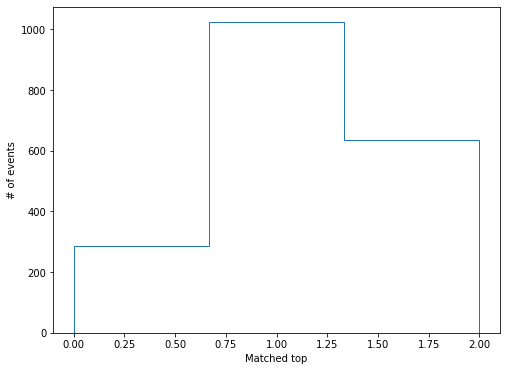

In [31]:
plt.figure(figsize=(8,6))
plt.hist(N_match_top_in_event, bins=3, histtype='step')
plt.xlabel('Matched top')
plt.ylabel('# of events')
plt.show()

In [32]:
W_plus_inv = []
W_minus_inv = []
tmp = 0
tmp_p = 0
for i in range(len(parton_eta)):
    tmp = np.sqrt( 2*parton_pt[i][1]*parton_pt[i][2]*( np.cosh(parton_eta[i][1] - parton_eta[i][2])  - np.cos( parton_phi[i][1] - parton_phi[i][2] )) )
    W_plus_inv.append(tmp)
    tmp_p = np.sqrt( 2*parton_pt[i][4]*parton_pt[i][5]*( np.cosh(parton_eta[i][4] - parton_eta[i][5])  - np.cos( parton_phi[i][4] - parton_phi[i][5] )) )
    W_minus_inv.append(tmp)

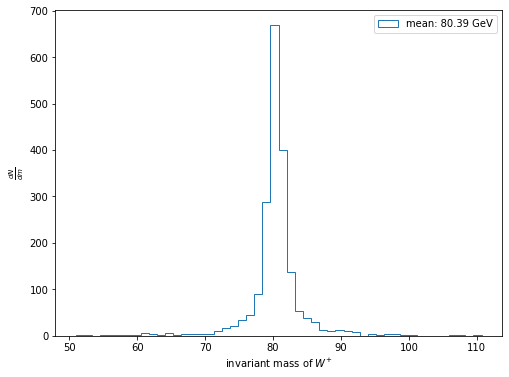

In [33]:
plt.figure(figsize=(8,6))
plt.hist(W_plus_inv, bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(W_plus_inv)))
plt.xlabel(r'invariant mass of $W^{+}$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

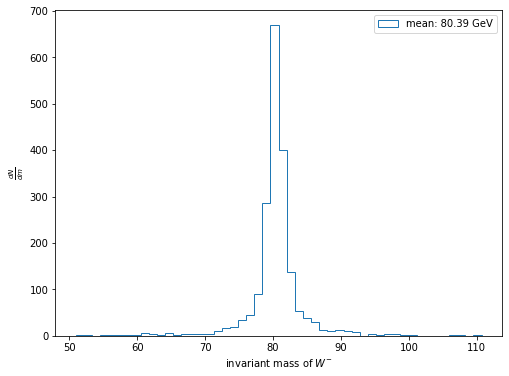

In [34]:
plt.figure(figsize=(8,6))
plt.hist(W_minus_inv,  bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(W_minus_inv)))
plt.xlabel(r'invariant mass of $W^{-}$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

In [35]:
top_inv = []
top_bar_inv = []
tmp = 0
tmp_p = 0
for i in range(len(N_match_top_in_event)):
    if N_match_top_in_event[i] == 2:
        pt_1 = parton_pt[i][0]
        pt_2 = parton_pt[i][1]
        pt_3 = parton_pt[i][2]

        px_1 = pt_1 * np.cos(parton_phi[i][0])
        px_2 = pt_2 * np.cos(parton_phi[i][1])
        px_3 = pt_3 * np.cos(parton_phi[i][2])

        py_1 = pt_1 * np.sin(parton_phi[i][0])
        py_2 = pt_2 * np.sin(parton_phi[i][1])
        py_3 = pt_3 * np.sin(parton_phi[i][2])

        pz_1 = pt_1 * np.sinh(parton_eta[i][0])
        pz_2 = pt_2 * np.sinh(parton_eta[i][1])
        pz_3 = pt_3 * np.sinh(parton_eta[i][2])

        e_1 = np.sqrt( (px_1**2 + py_1**2 + pz_1**2 ) + parton_mass[i][0]**2 )
        e_2 = np.sqrt( (px_2**2 + py_2**2 + pz_2**2 ) + parton_mass[i][1]**2 )
        e_3 = np.sqrt( (px_3**2 + py_3**2 + pz_3**2 ) + parton_mass[i][2]**2 )
        tmp = np.sqrt( (e_1 + e_2 + e_3)**2 - (px_1 + px_2 + px_3)**2 - (py_1 + py_2 + py_3)**2 - (pz_1 + pz_2 + pz_3)**2  )
        top_inv.append(tmp)
        # tmp_p = np.sqrt( 2*parton_pt[i][4]*parton_pt[i][5]*( np.cosh(parton_eta[i][4] - parton_eta[i][5])  - np.cos( parton_phi[i][4] - parton_phi[i][5] )) )
        # top_bar_inv.append(tmp)

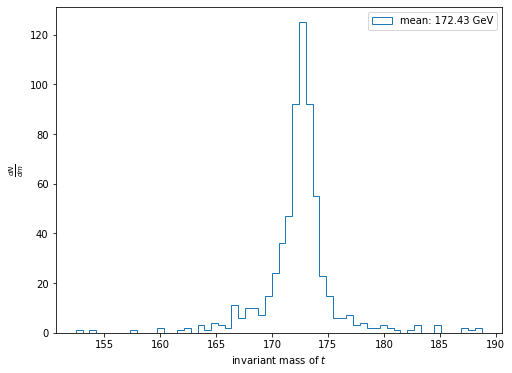

In [36]:
plt.figure(figsize=(8,6))
plt.hist(top_inv,  bins = 60 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(top_inv)))
plt.xlabel(r'invariant mass of $t$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

In [37]:
W_plus_inv_jet = []
W_minus_inv_jet = []

tmp = 0
tmp_p = 0

for i in range(len(N_match_top_in_event)):
    if N_match_top_in_event[i] == 2:
        for j in range(len(jet_parton_index[i])):
            if jet_parton_index[i][j] == 1:
                pt_1 = jet_pt[i][j]
                eta_1 = jet_eta[i][j]
                phi_1 = jet_phi[i][j]
                #print(pt_1, eta_1, phi_1)
            if jet_parton_index[i][j] == 2:
                pt_2 = jet_pt[i][j]
                eta_2 = jet_eta[i][j]
                phi_2 = jet_phi[i][j]
                #print(pt_2, eta_2, phi_2)
            

            if jet_parton_index[i][j] == 4:
                pt_3 = jet_pt[i][j]
                eta_3 = jet_eta[i][j]
                phi_3 = jet_phi[i][j]

            if jet_parton_index[i][j] == 5:
                pt_4 = jet_pt[i][j]
                eta_4 = jet_eta[i][j]
                phi_4 = jet_phi[i][j]

        tmp = np.sqrt( 2*pt_1*pt_2*( np.cosh( eta_1 - eta_2 ) - np.cos( phi_1 - phi_2 ) ) )
        tmp_p = np.sqrt( 2*pt_3*pt_4*( np.cosh( eta_3 - eta_4 ) - np.cos( phi_3 - phi_4 ) ) )

        W_plus_inv_jet.append(tmp)
        W_minus_inv_jet.append(tmp_p)

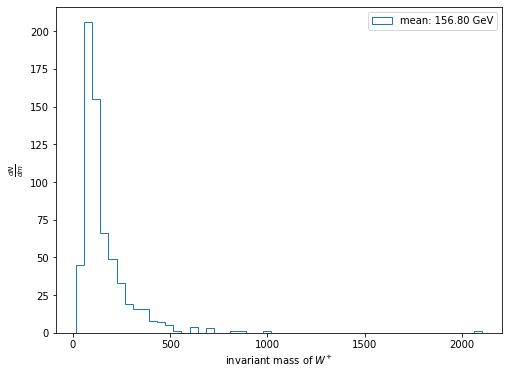

In [38]:
plt.figure(figsize=(8,6))
plt.hist(W_plus_inv_jet, bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(W_plus_inv_jet)))
plt.xlabel(r'invariant mass of $W^{+}$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

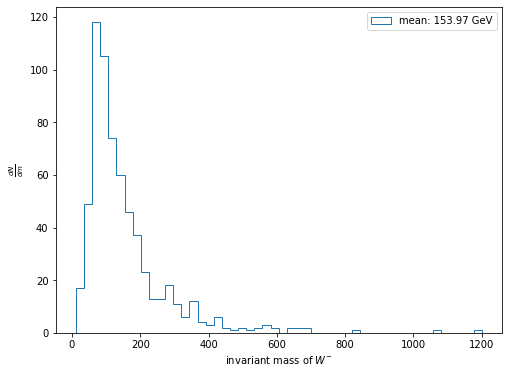

In [39]:
plt.figure(figsize=(8,6))
plt.hist(W_minus_inv_jet, bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(W_minus_inv_jet)))
plt.xlabel(r'invariant mass of $W^{-}$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

In [40]:
t_inv_jet = []
t_bar_inv_jet = []

tmp = 0
tmp_p = 0

for i in range(len(N_match_top_in_event)):
    if N_match_top_in_event[i] == 2:
        for j in range(len(jet_parton_index[i])):
            if jet_parton_index[i][j] == 0:
                pt_0 = jet_pt[i][j]
                eta_0 = jet_eta[i][j]
                phi_0 = jet_phi[i][j]
                px_0 = pt_0*np.cos( phi_0 )
                py_0 = pt_0*np.sin( phi_0 )
                pz_0 = pt_0*np.sinh( eta_0 )
                mass_0 = jet_mass[i][j]
                e_0 = np.sqrt( (px_0**2 + py_0**2 + pz_0**2 ) + mass_0**2 ) 

            if jet_parton_index[i][j] == 1:
                pt_1 = jet_pt[i][j]
                eta_1 = jet_eta[i][j]
                phi_1 = jet_phi[i][j]
                px_1 = pt_1*np.cos( phi_1 )
                py_1 = pt_1*np.sin( phi_1 )
                pz_1 = pt_1*np.sinh( eta_1 )
                mass_1 = jet_mass[i][j]
                e_1 = np.sqrt( (px_1**2 + py_1**2 + pz_1**2 ) + mass_1**2 ) 

            if jet_parton_index[i][j] == 2:
                pt_2 = jet_pt[i][j]
                eta_2 = jet_eta[i][j]
                phi_2 = jet_phi[i][j]
                px_2 = pt_2*np.cos( phi_2 )
                py_2 = pt_2*np.sin( phi_2 )
                pz_2 = pt_2*np.sinh( eta_2 )
                mass_2 = jet_mass[i][j]
                e_2 = np.sqrt( (px_2**2 + py_2**2 + pz_2**2 ) + mass_2**2 )

            if jet_parton_index[i][j] == 3:
                pt_3 = jet_pt[i][j]
                eta_3 = jet_eta[i][j]
                phi_3 = jet_phi[i][j]
                px_3 = pt_3*np.cos( phi_3 )
                py_3 = pt_3*np.sin( phi_3 )
                pz_3 = pt_3*np.sinh( eta_3 )
                mass_3 = jet_mass[i][j]
                e_3 = np.sqrt( (px_3**2 + py_3**2 + pz_3**2 ) + mass_3**2 )

            if jet_parton_index[i][j] == 4:
                pt_4 = jet_pt[i][j]
                eta_4 = jet_eta[i][j]
                phi_4 = jet_phi[i][j]
                px_4 = pt_4*np.cos( phi_4 )
                py_4 = pt_4*np.sin( phi_4 )
                pz_4 = pt_4*np.sinh( eta_4 )
                mass_4 = jet_mass[i][j]
                e_4 = np.sqrt( (px_4**2 + py_4**2 + pz_4**2 ) + mass_4**2 )

            if jet_parton_index[i][j] == 5:
                pt_5 = jet_pt[i][j]
                eta_5 = jet_eta[i][j]
                phi_5 = jet_phi[i][j]
                px_5 = pt_5*np.cos( phi_5 )
                py_5 = pt_5*np.sin( phi_5 )
                pz_5 = pt_5*np.sinh( eta_5 )
                mass_5 = jet_mass[i][j]
                e_5 = np.sqrt( (px_5**2 + py_5**2 + pz_5**2 ) + mass_5**2 )

        tmp = np.sqrt( (e_0 + e_1 + e_2)**2 - (px_0 + px_1 + px_2)**2 - (py_0 + py_1 + py_2)**2 - (pz_0 + pz_1 + pz_2)**2 )
        tmp_p = np.sqrt( (e_3 + e_4 + e_5)**2 - (px_3 + px_4 + px_5)**2 - (py_3 + py_4 + py_5)**2 - (pz_3 + pz_4 + pz_5)**2 )

        t_inv_jet.append(tmp)
        t_bar_inv_jet.append(tmp_p)


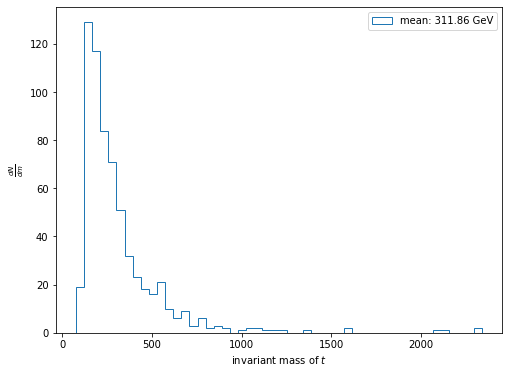

In [41]:
plt.figure(figsize=(8,6))
plt.hist(t_inv_jet, bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(t_inv_jet)))
plt.xlabel(r'invariant mass of $t$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

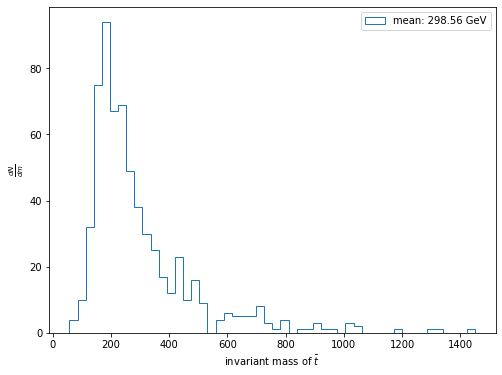

In [42]:
plt.figure(figsize=(8,6))
plt.hist(t_bar_inv_jet, bins = 50 ,histtype='step', label='mean: {0:.2f} GeV'.format(np.mean(t_bar_inv_jet)))
plt.xlabel(r'invariant mass of $\bar{t}$')
plt.ylabel(r'$\frac{dN}{dm}$')
plt.legend(loc='upper right')
plt.show()

## Saved selected events
---

In [43]:
# lene = len(parton_pdgid)

# #Save the event which pass the selection
# with h5py.File("./output/event_record_pptt_10k_atlas.h5",'w') as f:
#     dt = h5py.vlen_dtype(np.dtype('float16'))

#     hdf5_jet_parton_index = f.create_dataset('jet_parton_index', (lene, ), dtype=dt)
#     hdf5_jet_barcode = f.create_dataset('jet_barcode', (lene, ), dtype=dt)
#     hdf5_jet_pt = f.create_dataset('jet_pt', (lene, ), dtype=dt)
#     hdf5_jet_eta = f.create_dataset('jet_eta', (lene, ), dtype=dt)
#     hdf5_jet_phi = f.create_dataset('jet_phi', (lene, ), dtype=dt)
#     hdf5_jet_mass = f.create_dataset('jet_mass', (lene, ), dtype=dt)
#     hdf5_jet_btag = f.create_dataset('jet_btag', (lene, ), dtype=dt)

#     for i in range(lene):
#         hdf5_jet_parton_index[i] = jet_parton_index[i]
#         hdf5_jet_barcode[i] = jet_barcode[i]
#         hdf5_jet_pt[i] = jet_pt[i]
#         hdf5_jet_eta[i] = jet_eta[i]
#         hdf5_jet_phi[i] = jet_phi[i]
#         hdf5_jet_mass[i] = jet_mass[i]
#         hdf5_jet_btag[i] = jet_btag[i]

#     hdf5_parton_jet_index = f.create_dataset('parton_jet_index', (lene, ), dtype=dt)
#     hdf5_parton_pdgid = f.create_dataset('parton_pdgid', (lene, ), dtype=dt)
#     hdf5_parton_barcode = f.create_dataset('parton_barcode', (lene, ), dtype=dt)
#     hdf5_parton_pt = f.create_dataset('parton_pt', (lene, ), dtype=dt)
#     hdf5_parton_eta = f.create_dataset('parton_eta', (lene, ), dtype=dt)
#     hdf5_parton_phi = f.create_dataset('parton_phi', (lene, ), dtype=dt)
#     hdf5_parton_mass = f.create_dataset('parton_mass', (lene, ), dtype=dt)
#     hdf5_N_match_top_in_event = f.create_dataset('N_match_top_in_event', data = N_match_top_in_event)

#     for i in range(lene):
#         hdf5_parton_jet_index[i] = parton_jet_index[i]
#         hdf5_parton_pdgid[i] = parton_pdgid[i]
#         hdf5_parton_barcode[i] = parton_barcode[i]
#         hdf5_parton_pt[i] = parton_pt[i]
#         hdf5_parton_eta[i] = parton_eta[i]
#         hdf5_parton_phi[i] = parton_phi[i]
#         hdf5_parton_mass[i] = parton_mass[i]
#         #hdf5_N_match_top_in_event[i] = N_match_top_in_event[i]
    

In [44]:
len(N_match_top_in_event)

1946

In [45]:
lene

NameError: name 'lene' is not defined